Auteur : Audrey Hohmann

# Projet P7 : Notebook_modèle de prédiction
 
## Mission : Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique. 

## Data : Kaggle Home Credit Default Risk

Notebook inspiré des notebooks kaggle suivants : 
* https://www.kaggle.com/code/jsaguiar/lightgbm-with-simple-features/script?utm_medium=email&utm_content=nov-18-has-completed-mentoring-session-student&bsft_clkid=c383d801-b816-4d91-bed2-bce1da1df289&bsft_uid=54d38473-b877-4917-828f-57101c869f00&bsft_mid=8b2cf8bc-ff00-49bd-ba21-f71f9e476cd2&bsft_eid=7244055d-47f0-a6f2-c394-7a20ebb3a726&bsft_txnid=71f40185-343e-4c6f-9a7d-c87d70160352&bsft_mime_type=html&bsft_ek=2023-06-09T08%3A34%3A41Z&bsft_aaid=a265d396-7432-4eb2-9c9a-ba5eea75629e&bsft_tv=13
* https://www.kaggle.com/code/profammons/eda-feature-engineering-and-supervised-ml#Feature-Engineering
* https://www.kaggle.com/code/syahbima/home-credit-risk-modelling
* https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook#Feature-Engineering-Outcomes

In [2]:
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns

sns.set_theme()

from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
pd.options.mode.chained_assignment = None 

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Data description

*application_{train|test}.csv --
This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

*bureau.csv --
All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

*bureau_balance.csv --
Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

*POS_CASH_balance.csv --
Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

*credit_card_balance.csv --
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

*previous_application.csv --
All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

*installments_payments.csv --
Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

*HomeCredit_columns_description.csv --
This file contains descriptions for the columns in the various data files.

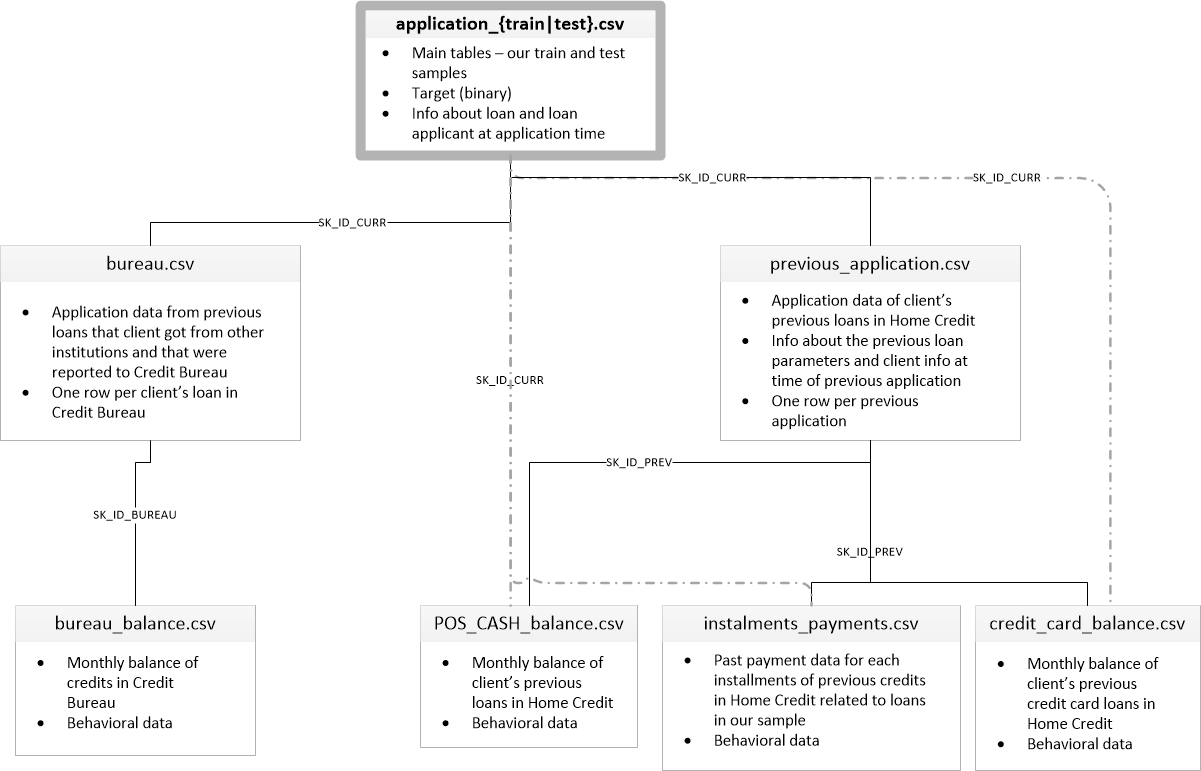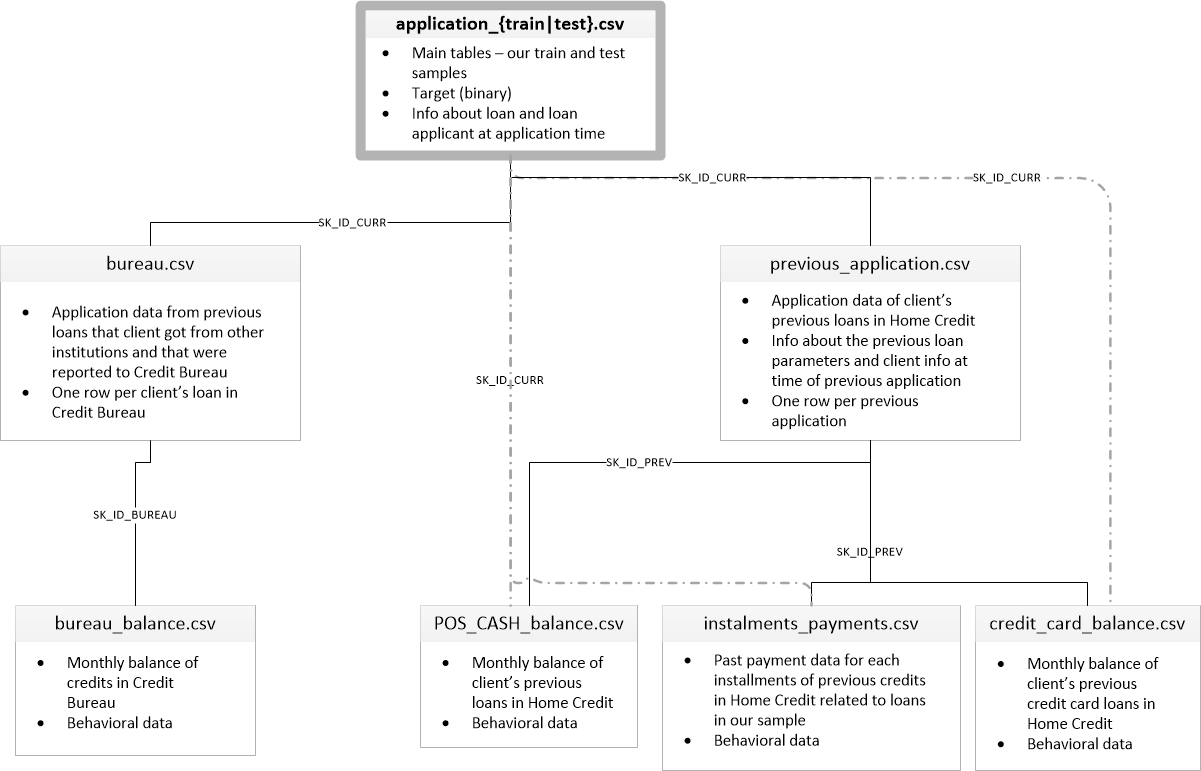

# DATA LOAD

In [6]:
PATH=""

In [6]:
#df_apptrain_ohe = pd.read_csv(PATH+"data_P7_clean.csv")

In [7]:
#print('Size of application_train clean data ', df_apptrain_ohe.shape)

Size of application_train clean data  (305900, 130)


In [8]:
#df_apptrain_ohe.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_infrequent_sklearn,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_infrequent_sklearn,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_infrequent_sklearn,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,OCCUPATION_TYPE_infrequent_sklearn,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_infrequent_sklearn
0,100002,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,1,Single / not married,House / apartment,0.018801,9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.262949,0.139376,0.9722,0.0833,0.9722,0.0833,0.9722,0.0833,0.0149,No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1,2.007889,0.121978,0.060749,-0.067329,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,100003,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,3,Married,House / apartment,0.003541,16765,-1188.0,-1186.0,-291,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.622246,NaN,0.9851,0.2917,0.9851,0.2917,0.9851,0.2917,0.0714,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,4.790750,0.132217,0.027598,-0.070862,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,100004,Revolving loans,M

In [7]:
df_train_full = pd.read_csv(PATH+"df_train_full.csv")

In [8]:
print('Size of application_train clean data ', df_train_full.shape)

Size of application_train clean data  (305900, 680)


In [9]:
df_train_full.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_infrequent_sklearn,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_infrequent_sklearn,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_infrequent_sklearn,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,OCCUPATION_TYPE_infrequent_sklearn,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_infrequent_sklearn,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CRED

In [125]:
df_train_full.to_parquet('df_train_full.parquet')

In [10]:
df_train = df_train_full

In [10]:
df_train.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_infrequent_sklearn,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_infrequent_sklearn,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_infrequent_sklearn,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,OCCUPATION_TYPE_infrequent_sklearn,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_infrequent_sklearn,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_M

In [11]:
# Vérification des valeurs infinies par colonne
columns_with_infinities = []
for column in df_train.select_dtypes(include=np.number).columns:  # Boucle sur chaque colonne
    if np.isinf(df_train[column].values).any():
        columns_with_infinities.append(column)

# Affichage des colonnes contenant des valeurs infinies
if len(columns_with_infinities) > 0:
    print("Les colonnes suivantes contiennent des valeurs infinies :")
    for column in columns_with_infinities:
        print(f"Colonne {column}")
else:  
    print("Aucune colonne ne contient de valeurs infinies.")

Les colonnes suivantes contiennent des valeurs infinies :
Colonne PREV_APP_CREDIT_PERC_MAX
Colonne REFUSED_APP_CREDIT_PERC_MAX
Colonne INSTAL_PAYMENT_PERC_MAX


In [12]:
df_train['PREV_APP_CREDIT_PERC_MAX'].describe()

count    2.896360e+05
mean              inf
std               NaN
min      0.000000e+00
25%      1.000000e+00
50%      1.042525e+00
75%      1.131397e+00
max               inf
Name: PREV_APP_CREDIT_PERC_MAX, dtype: float64

# Model Building

In [13]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, get_scorer_names, make_scorer, roc_curve, RocCurveDisplay
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from collections import Counter

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [14]:
cols_to_drop = list(df_train.select_dtypes('object').columns) + ['TARGET', 'SK_ID_CURR','PREV_APP_CREDIT_PERC_MAX', 'REFUSED_APP_CREDIT_PERC_MAX', 'INSTAL_PAYMENT_PERC_MAX']

In [15]:
X = df_train.drop(cols_to_drop, axis=1)
y = df_train['TARGET']
identifiants = df_train['SK_ID_CURR']

In [16]:
y.head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [36]:
Counter(y)

Counter({1: 24748, 0: 281152})

# X_test = df_test_ohe.drop(cols_to_drop, axis=1)

## Using Imputation for missing values

In [17]:
imp_med = SimpleImputer(missing_values=np.nan, strategy='median')

In [18]:
X_med = imp_med.fit_transform(X)

In [19]:
np.sum(np.isnan(X_med))

0

## Train test split

In [20]:
X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X_med, y, identifiants, test_size=0.25, random_state=42)

In [21]:
print(f"Nous avons X_train de forme {X_train.shape} et y_train de forme {y_train.shape} ")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape} ")

Nous avons X_train de forme (229425, 663) et y_train de forme (229425,) 
Nous avons X_test de forme (76475, 663) et y_test de forme (76475,) 


In [22]:
y_train.value_counts(normalize=True)

0    0.918644
1    0.081356
Name: TARGET, dtype: float64

In [23]:
#Standard_scaler
scaler = StandardScaler()
std_scaler = scaler.fit(X_med) 
X_std = std_scaler.transform(X_med)
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

In [24]:
import pickle

In [25]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(std_scaler, f)

In [26]:
#transformation en df
X_train_std_df = pd.DataFrame(X_train_std, columns = X.columns)
X_train_std_df['SK_ID_CURR']=id_train.values
X_test_std_df = pd.DataFrame(X_test_std, columns = X.columns)
X_test_std_df['SK_ID_CURR']=id_test.values

In [157]:
X_train_std_df.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_infrequent_sklearn,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_infrequent_sklearn,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_infrequent_sklearn,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,OCCUPATION_TYPE_infrequent_sklearn,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_infrequent_sklearn,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TY

In [ ]:
X_test_std_df.to_csv('X_test_full.csv', index=False)

In [27]:
X_test_std_df.to_parquet('X_test_full.parquet')

## Using SMOTE for unbalanced data

In [247]:
#transform the dataset
oversample = SMOTE(random_state=42)
X_train_sm, y_train_sm = oversample.fit_resample(X_train, y_train)

In [248]:
print('Resampled dataset shape %s' % Counter(y_train_sm))

Resampled dataset shape Counter({0: 210760, 1: 210760})


In [249]:
print(f"Nous avons X_train de forme {X_train_sm.shape} et y_train de forme {y_train_sm.shape} ")
print(f"Nous avons X_test de forme {X_test.shape} et y_test de forme {y_test.shape} ")

Nous avons X_train de forme (421520, 664) et y_train de forme (421520,) 
Nous avons X_test de forme (76475, 664) et y_test de forme (76475,) 


In [250]:
y_train_sm.value_counts(normalize=True)

0    0.5
1    0.5
Name: TARGET, dtype: float64

In [251]:
X_train_sm = std_scaler.transform(X_train_sm)

## Baseline and unbalanced data

In [253]:
# Baseline
dummy_clf =DummyClassifier(strategy="prior", random_state=42)
dummy_clf.fit(X_train_std, y_train)

DummyClassifier(random_state=42)

In [254]:
y_proba_dum = dummy_clf.predict_proba(X_test_std)
print(y_proba_dum.mean())
print(y_proba_dum.std())

0.5000000000000001
0.4186444371799063


In [255]:
y_pred_dum = dummy_clf.predict(X_test_std)

In [256]:
dummy_clf.score(X_test_std, y_test)

0.9204576659038901

dans le cas de l'utilisation d'un dummy classifier sans rééquilibrage des données, nous constatons que nous obtenons une très bonne accuracy (0,92), cette métrique n'est pas adaptée avec cet algorithme qui choisit comme stratégie la classe la plus représentée. La valeur 0,92 est proche de la proportion de 0 (prêts remboursés) présente dans notre dataset). pour info, seuil de classification fixé par defaut à 50 % avec un predict. D'autres métriques sont calculées ci-dessous comme precision, recall, f1. 

Text(110.44999999999997, 0.5, 'predicted label')

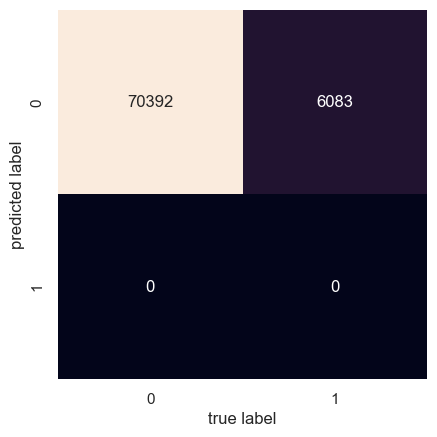

In [257]:
mat = confusion_matrix(y_test, y_pred_dum)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [258]:
precision_dum = precision_score(y_test, y_pred_dum) # Positive Predictive Value : (TP/TP+FP)
recall_dum = recall_score(y_test, y_pred_dum) #True positive rate : (TP/TP+FN)
f1_dum = f1_score(y_test, y_pred_dum) # mean of the precision and recall
print(precision_dum)
print(recall_dum)
print(f1_dum)

0.0
0.0
0.0


In [259]:
# Baseline with SMOTE data
dummy_clf =DummyClassifier(strategy="prior", random_state=42)
dummy_clf.fit(X_train_sm, y_train_sm)
y_proba_dum_sm = dummy_clf.predict_proba(X_test_std)
print(y_proba_dum_sm.mean())
print(y_proba_dum_sm.std())

0.5
0.0


In [260]:
y_pred_dum_sm = dummy_clf.predict(X_test_std)

In [261]:
dummy_clf.score(X_test_std, y_test)

0.9204576659038901

Text(110.44999999999997, 0.5, 'predicted label')

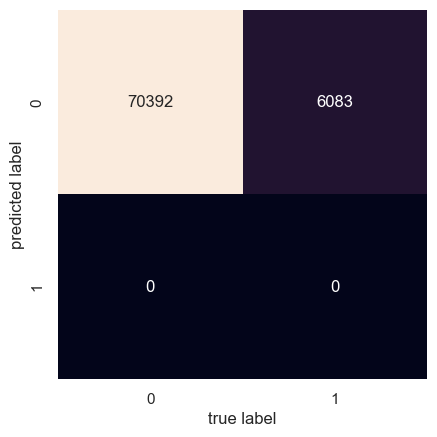

In [262]:
mat = confusion_matrix(y_test, y_pred_dum_sm)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [81]:
precision_dum = precision_score(y_test, y_pred_dum_sm) # Positive Predictive Value : (TP/TP+FP)
recall_dum = recall_score(y_test, y_pred_dum_sm) #True positive rate : (TP/TP+FN)
f1_dum = f1_score(y_test, y_pred_dum_sm) # mean of the precision and recall
print(precision_dum)
print(recall_dum)
print(f1_dum)

0.0
0.0
0.0


## MODEL statements

In [53]:
log_reg = LogisticRegression(C = 0.0001, random_state=42)

In [54]:
rfc_clf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = -1, class_weight="balanced")

In [55]:
lgb_clf = LGBMClassifier(n_estimators=100, objective = 'binary', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   class_weight="balanced",
                                   subsample = 0.8, n_jobs = -1, random_state = 42)

## Using ML FLOW

In [51]:
import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn
from urllib.parse import urlparse

In [52]:
# chemin absolu vers le dossier mlruns
mlflow_tracking_uri = os.path.abspath("mlruns")

# variable d'environnement MLFLOW_TRACKING_URI
os.environ["MLFLOW_TRACKING_URI"] = mlflow_tracking_uri


## Evaluating model performance

L’entreprise considère que le coût d’un FN (un mauvais client classé bon client) est 10 fois supérieur au coût d’un FP (bon client classé mauvais client).

In [152]:
def calculate_metier_score(y_true, y_pred):
    cost_fp = 1  # Coût d'un faux positif
    cost_fn = 10  # Coût d'un faux négatif
    score_metier = (cost_fn * np.sum(y_true * (1 - y_pred)) +
                    cost_fp * np.sum((1 - y_true) * y_pred))
    return score_metier

In [153]:
scorer_metier = make_scorer(calculate_metier_score, greater_is_better=False)

### cross validation with stratified kfold by default

In [58]:
mlflow.autolog(log_models=False, log_model_signatures = False, silent=True)

In [657]:
# sans ML flow
def scores(clf, ncv, X, y, pipeline=False):
    scorer_mapping = {
        'AUC' : 'roc_auc',
        'Precision' : 'precision',
        'Recall' : 'recall',
        'Accuracy': 'accuracy',
        'F1 Score': 'f1',
        'Score metier': scorer_metier
    }
    
    if pipeline == True: 
        model = Pipeline([('sampling', SMOTE()), ('classification', clf)])
        scores_estimator = cross_validate(model, X, y, scoring=scorer_mapping, cv=ncv)
        run_name += '_SMOTE'
    else:
        scores_estimator = cross_validate(clf, X, y, scoring=scorer_mapping, cv=ncv)
    
   
        for score_name in scorer_mapping.keys():
            score_mean = scores_estimator['test_' + score_name].mean().round(4)
            score_std = scores_estimator['test_' + score_name].std().round(4)

        print(f"Avec le modèle {clf.__class__.__name__} en validation croisée, {score_name} moyen est de {score_mean}, avec un écart-type de {score_std}")

In [272]:
#avec MLFLOW
def scores(clf, ncv, X, y, pipeline=False):
    scorer_mapping = {
        'AUC' : 'roc_auc',
        'Precision' : 'precision',
        'Recall' : 'recall',
        'Accuracy': 'accuracy',
        'F1 Score': 'f1',
        'Score metier': scorer_metier
    }
    
    run_name = clf.__class__.__name__ + str(int(time.time()))
    


    with mlflow.start_run(run_name=run_name):
        # Logging tags
        # run_name.
        mlflow.set_tag(key='Run name', value=run_name)
        # Goal.
        mlflow.set_tag(key='Goal', value='Check model performance and find the best model.')
        # Modeling exp.
        mlflow.set_tag(key='Modeling technique', value=clf.__class__.__name__ )
        
        
        for score_name in scorer_mapping.keys():
            if pipeline == True: 
                model = Pipeline([('sampling', SMOTE()), ('classification', clf)])
                scores_estimator = cross_validate(model, X, y, scoring=scorer_mapping[score_name], cv=ncv)
                run_name += '_SMOTE'
            else:
                scores_estimator = cross_validate(clf, X, y, scoring=scorer_mapping[score_name], cv=ncv)

            score_mean = scores_estimator['test_score'].mean().round(4)
            score_std = scores_estimator['test_score'].std().round(4)

            # Enregistrer les métriques dans MLflow
            mlflow.log_metric(f"{score_name}_mean", score_mean)
            mlflow.log_metric(f"{score_name}_std", score_std)

            # Enregistrer les paramètres dans MLflow
            mlflow.log_param("classifieur", clf.__class__.__name__)

            # Logging the SVC model.
            mlflow.sklearn.log_model(sk_model=clf, artifact_path=clf.__class__.__name__ + '_model')

            print(f"Avec le modèle {clf.__class__.__name__} en validation croisée, {score_name} moyen est de {score_mean}, avec un écart-type de {score_std}")


In [273]:
mlflow.set_experiment('P7 cross validation full data')

2023/06/29 16:23:54 INFO mlflow.tracking.fluent: Experiment with name 'P7 cross validation full data' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/audreyhohmann/Documents/Formation/OCR/P7/mlruns/869195313761066411', creation_time=1688048634169, experiment_id='869195313761066411', last_update_time=1688048634169, lifecycle_stage='active', name='P7 cross validation full data', tags={}>

In [274]:
%%time
scores(dummy_clf, 10, X_train_std, y_train, pipeline=True)

Avec le modèle DummyClassifier en validation croisée, AUC moyen est de 0.5, avec un écart-type de 0.0
Avec le modèle DummyClassifier en validation croisée, Precision moyen est de 0.0, avec un écart-type de 0.0
Avec le modèle DummyClassifier en validation croisée, Recall moyen est de 0.0, avec un écart-type de 0.0
Avec le modèle DummyClassifier en validation croisée, Accuracy moyen est de 0.9186, avec un écart-type de 0.0
Avec le modèle DummyClassifier en validation croisée, F1 Score moyen est de 0.0, avec un écart-type de 0.0
Avec le modèle DummyClassifier en validation croisée, Score metier moyen est de -18665.0, avec un écart-type de 5.0
CPU times: user 29min 35s, sys: 4min 5s, total: 33min 40s
Wall time: 12min 38s


In [275]:
%%time
scores(log_reg, 10, X_train_std, y_train, pipeline=False) #without smote

Avec le modèle LogisticRegression en validation croisée, AUC moyen est de 0.7603, avec un écart-type de 0.0046
Avec le modèle LogisticRegression en validation croisée, Precision moyen est de 0.6566, avec un écart-type de 0.0888
Avec le modèle LogisticRegression en validation croisée, Recall moyen est de 0.0055, avec un écart-type de 0.0006
Avec le modèle LogisticRegression en validation croisée, Accuracy moyen est de 0.9188, avec un écart-type de 0.0001
Avec le modèle LogisticRegression en validation croisée, F1 Score moyen est de 0.0108, avec un écart-type de 0.0011
Avec le modèle LogisticRegression en validation croisée, Score metier moyen est de -18568.7, avec un écart-type de 12.3049
CPU times: user 14min 14s, sys: 59.8 s, total: 15min 14s
Wall time: 4min 51s


In [276]:
%%time
scores(log_reg, 10, X_train_std, y_train, pipeline=True) #with smote

Avec le modèle LogisticRegression en validation croisée, AUC moyen est de 0.7509, avec un écart-type de 0.0045
Avec le modèle LogisticRegression en validation croisée, Precision moyen est de 0.1698, avec un écart-type de 0.0022
Avec le modèle LogisticRegression en validation croisée, Recall moyen est de 0.6575, avec un écart-type de 0.0113
Avec le modèle LogisticRegression en validation croisée, Accuracy moyen est de 0.7107, avec un écart-type de 0.0023
Avec le modèle LogisticRegression en validation croisée, F1 Score moyen est de 0.2697, avec un écart-type de 0.0033
Avec le modèle LogisticRegression en validation croisée, Score metier moyen est de -12413.2, avec un écart-type de 189.9636
CPU times: user 1h 22min 19s, sys: 7min 55s, total: 1h 30min 14s
Wall time: 30min 53s


In [277]:
%%time
scores(rfc_clf, 10, X_train_std, y_train,  pipeline=False)

Avec le modèle RandomForestClassifier en validation croisée, AUC moyen est de 0.7223, avec un écart-type de 0.006
Avec le modèle RandomForestClassifier en validation croisée, Precision moyen est de 0.4827, avec un écart-type de 0.1406
Avec le modèle RandomForestClassifier en validation croisée, Recall moyen est de 0.0017, avec un écart-type de 0.0011
Avec le modèle RandomForestClassifier en validation croisée, Accuracy moyen est de 0.9186, avec un écart-type de 0.0001
Avec le modèle RandomForestClassifier en validation croisée, F1 Score moyen est de 0.0033, avec un écart-type de 0.0022
Avec le modèle RandomForestClassifier en validation croisée, Score metier moyen est de -18637.1, avec un écart-type de 18.1408
CPU times: user 3min 37s, sys: 2min 10s, total: 5min 47s
Wall time: 3h 1min 3s


In [278]:
%%time
scores(lgb_clf, 10, X_train_std, y_train, pipeline=False)

Avec le modèle LGBMClassifier en validation croisée, AUC moyen est de 0.7718, avec un écart-type de 0.0045
Avec le modèle LGBMClassifier en validation croisée, Precision moyen est de 0.1769, avec un écart-type de 0.0023
Avec le modèle LGBMClassifier en validation croisée, Recall moyen est de 0.687, avec un écart-type de 0.0112
Avec le modèle LGBMClassifier en validation croisée, Accuracy moyen est de 0.7145, avec un écart-type de 0.0017
Avec le modèle LGBMClassifier en validation croisée, F1 Score moyen est de 0.2814, avec un écart-type de 0.0039
Avec le modèle LGBMClassifier en validation croisée, Score metier moyen est de -11807.8, avec un écart-type de 202.6735
CPU times: user 2h 45min 5s, sys: 5min 4s, total: 2h 50min 10s
Wall time: 1h 19min 42s


## Hyperparameter optimisation on best model

In [113]:
# sans Ml flow

def GSCVscores(estimator, parameters, X, y, ncv=10, scoring=None, random_state=42):
    
        if scoring is None:
            scoring = ['roc_auc', 'recall', 'accuracy']

        clf = GridSearchCV(estimator, param_grid=parameters,n_jobs=-1, scoring=scoring, 
                           cv=ncv, refit='AUC')
        clf.fit(X, y)
        df_gridscv = pd.DataFrame(clf.cv_results_)

        results = {'score': [], 'best_score': [], 'best_params': [], 'fit_time': []}
        for score in scoring:
            df_gridscv_best = df_gridscv[df_gridscv[f'mean_test_{score}'] == df_gridscv[f'mean_test_{score}'].max()]
            results['score'].append(score)
            results['best_score'].append(df_gridscv_best[f'mean_test_{score}'].values[0])
            results['best_params'].append(df_gridscv_best['params'].values[0])
            results['fit_time'].append(df_gridscv_best['mean_fit_time'].values[0])

        return pd.DataFrame(results)

In [59]:
#Avec Ml flow

def GSCVscores(estimator, parameters, X, y, ncv=10, scoring=None, random_state=42):
    run_name = estimator.__class__.__name__ + str(int(time.time()))

    with mlflow.start_run(run_name=run_name):
        # Logging tags
        mlflow.set_tag(key='Run name', value=run_name)
        mlflow.set_tag(key='Goal', value='Find optimised hyperparameters with GridSearchCV.')
        mlflow.set_tag(key='Modeling technique', value=estimator.__class__.__name__)

        if scoring is None:
            scoring = ['roc_auc', 'accuracy']

        clf = GridSearchCV(estimator, param_grid=parameters, n_jobs=-1, scoring=scoring, cv=ncv, refit='AUC')
        clf.fit(X, y)
        df_gridscv = pd.DataFrame(clf.cv_results_)

        results = {'score': [], 'best_score': [], 'best_params': [], 'fit_time': []}
        for score in scoring:
            df_gridscv_best = df_gridscv[df_gridscv[f'mean_test_{score}'] == df_gridscv[f'mean_test_{score}'].max()]
            results['score'].append(score)
            results['best_score'].append(df_gridscv_best[f'mean_test_{score}'].values[0])
            results['best_params'].append(df_gridscv_best['params'].values[0])
            results['fit_time'].append(df_gridscv_best['mean_fit_time'].values[0])

        # Enregistrer les paramètres dans MLflow
        for param_name, param_value in clf.best_params_.items():
            mlflow.log_param(param_name, param_value)

        # Enregistrer les métriques dans MLflow
        for score_name, best_score in zip(results['score'], results['best_score']):
            mlflow.log_metric(f"best_{score_name}", best_score)

        return pd.DataFrame(results)


In [60]:
LGBM_parameters={"n_estimators" : [200, 500, 1000],
                 "learning_rate" : [0.05], 
                 "reg_alpha": [0.1], 
                 "reg_lambda": [0.1], 
                "class_weight": ["balanced"],
                 "num_leaves": [15, 31, 63],
                 "subsample": [0.8], 
                 "n_jobs": [-1]}

In [61]:
scorer_mapping = {
        'AUC' : 'roc_auc',
        'Precision' : 'precision',
        'Recall' : 'recall',
        'Accuracy': 'accuracy',
        'F1 Score': 'f1',
        'Score metier': scorer_metier
    }

In [62]:
mlflow.set_experiment('P7 search optimised hyperparameters full data')

<Experiment: artifact_location='/Users/audreyhohmann/Documents/Formation/OCR/P7/mlruns/463447229863918229', creation_time=1688072259728, experiment_id='463447229863918229', last_update_time=1688072259728, lifecycle_stage='active', name='P7 search optimised hyperparameters full data', tags={}>

In [63]:
%%time
results_LGBM = GSCVscores(LGBMClassifier(), LGBM_parameters,
                    X_train_std, y_train,
                   scoring=scorer_mapping,  
                   ncv=10)

CPU times: user 6min 1s, sys: 21.3 s, total: 6min 22s
Wall time: 1h 22min 18s


In [64]:
results_LGBM

,score,best_score,best_params,fit_time
0,AUC,0.779935,"{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 15, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}",295.301261
1,Precision,0.242268,"{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}",611.960715
2,Recall,0.693918,"{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 200, 'n_jobs': -1, 'num_leaves': 15, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}",332.547360
3,Accuracy,0.840423,"{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}",611.960715
4,F1 Score,0.315426,"{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 1000, 'n_jobs': -1, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}",611.960715
5,Score metier,-11493.100000,"{'class_weight': 'balanced', 'learning_rate': 0.05, 'n_estimators': 500, 'n_jobs': -1, 'num_leaves': 15, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.8}",295.301261


## Training the model with optimised hyperparameters

In [32]:
best_lgbm_params = {'class_weight': 'balanced', 
                    'learning_rate': 0.05, 'n_estimators': 500, 
                    'n_jobs': -1, 'num_leaves': 15, 'reg_alpha': 0.1, 
                    'reg_lambda': 0.1, 'subsample': 0.8}

In [33]:
clf = LGBMClassifier(**best_lgbm_params)

In [34]:
%%time
clf.fit(X_train_std, y_train)

CPU times: user 4min 39s, sys: 10.9 s, total: 4min 50s
Wall time: 55.4 s


LGBMClassifier(class_weight='balanced', learning_rate=0.05, n_estimators=500,
               num_leaves=15, reg_alpha=0.1, reg_lambda=0.1, subsample=0.8)

In [159]:
def eval_metrics(actual, pred): 
    best_score = calculate_metier_score(actual, pred)
    accuracy = accuracy_score(actual, pred).round(4)
    precision = precision_score(actual, pred).round(4)
    recall = recall_score(actual, pred).round(4)
    f1 = f1_score(actual, pred).round(4)
    return best_score, accuracy, precision, recall, f1

In [160]:
y_pred_train = clf.predict(X_train_std)

In [161]:
y_pred_proba_train = clf.predict_proba(X_train_std)[:, 1]

In [162]:
# Appel de la fonction eval_metrics
best_score, accuracy, f1, precision, recall = eval_metrics(y_train, y_pred_train)
roc_auc = roc_auc_score(y_train, y_pred_proba_train).round(4)

# Affichage des métriques
print("Score métier:", best_score)
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Score métier: 97526
ROC AUC: 0.8349
Accuracy: 0.7468
Precision: 0.7653
Recall: 0.3296
F1 Score: 0.2101


In [163]:
y_pred = clf.predict(X_test_std)

In [164]:
#Proba estimée d'appartenir à la classe 1 
y_pred_proba = clf.predict_proba(X_test_std)[:, 1]

In [165]:
y_pred_proba

array([0.47979039, 0.70167267, 0.66787576, ..., 0.24226182, 0.14297167,
       0.2707097 ])

In [167]:
# Appel de la fonction eval_metrics
best_score, accuracy, f1, precision, recall = eval_metrics(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba).round(4)

# Affichage des métriques
print("Score métier:", best_score)
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Score métier: 37614
ROC AUC: 0.7838
Accuracy: 0.7334
Precision: 0.6854
Recall: 0.2903
F1 Score: 0.1841


In [168]:
metier_score = calculate_metier_score(y_test, y_pred_proba)

In [169]:
metier_score

50249.67106070425

In [170]:
y_pred_proba

array([0.47979039, 0.70167267, 0.66787576, ..., 0.24226182, 0.14297167,
       0.2707097 ])

In [171]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

In [172]:
fpr[-10:]

array([0.98741334, 0.9877827 , 0.9877827 , 0.99190249, 0.99190249,
       0.99366405, 0.99366405, 0.99543982, 0.99543982, 1.        ])

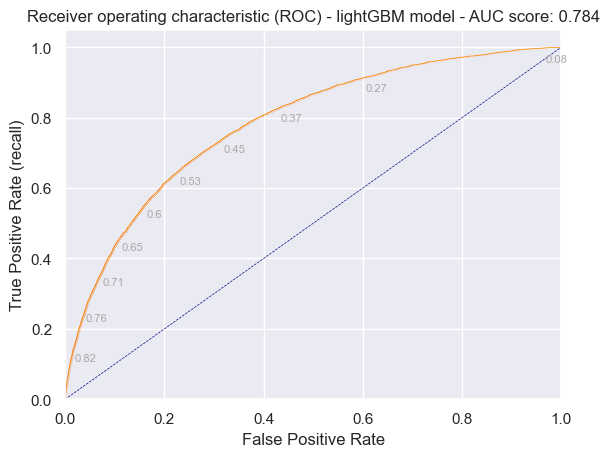

In [173]:
#courbe ROC avec les taux de faux positifs (fpr) et les taux de vrais positifs (tpr) et les probabilités

proba_step = 1000
plt.figure()
lw = 0.5
plt.plot(fpr, tpr, color='darkorange', lw=lw, marker='.', markersize=0.01)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
if proba_step is not None:
    i = 0
    for x, y, txt in zip(fpr, tpr, thresholds):
        if i % proba_step == 0:
            plt.annotate(np.round(txt, 2), (x, y - 0.04), color='darkgray', fontsize=8)
        i += 1
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (recall)')
plt.title('Receiver operating characteristic (ROC) - lightGBM model - AUC score: {}'.format(str(np.round(roc_auc,3))))
plt.show()

In [174]:
M = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = M.ravel() 

In [175]:
tpr_w = tp / (tp + fn * 10)

In [176]:
frp = fp / (fp + tn)

In [177]:
df_results = pd.DataFrame({'y_test': y_test.values, 'y_pred_proba' : y_pred_proba})

In [178]:
df_results = df_results.sort_values('y_pred_proba')

In [179]:
df_results.head()

,y_test,y_pred_proba
1279,0,0.017535
10848,0,0.019105
58944,0,0.019574
4630,0,0.021079
48354,0,0.021236


In [180]:
steps = np.percentile(df_results['y_pred_proba'], range (0, 100, 5))

In [181]:
steps

array([0.01753471, 0.09640284, 0.12799558, 0.15568572, 0.18231411,
       0.2078789 , 0.23297867, 0.25974353, 0.28813544, 0.31750419,
       0.35011766, 0.38295076, 0.41894366, 0.4560634 , 0.49674417,
       0.54113695, 0.59065108, 0.64309817, 0.70203717, 0.77797611])

In [90]:
#proba_step = 1000

In [91]:
#steps = np.quantile(df_results['y_pred_proba'], q=np.array(range(0,len(df_results), proba_step))/len(df_results))

In [92]:
def custom_recall_score(y_true, y_pred, penality=10):
    M = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = M.ravel() 
    return tp / (tp + fn * penality)

In [93]:
precision_results = []
recall_results = []
custom_recall_results = []
score_metier_results = []

In [94]:
for step in steps:
    y_pred_step = (df_results['y_pred_proba'] >= step)
    precision_results.append(precision_score(df_results['y_test'], y_pred_step))
    recall_results.append(recall_score(df_results['y_test'], y_pred_step))
    custom_recall_results.append(custom_recall_score(df_results['y_test'], y_pred_step))
    score_metier_results.append(calculate_metier_score(df_results['y_test'], y_pred_step))

In [95]:
df_scores = pd.DataFrame({'precision_score': precision_results,
                          'recall_score': recall_results,
                          'custom_recall_score': custom_recall_results,
                          'score_metier': score_metier_results,
                          'probas': steps})

In [96]:
df_scores

,precision_score,recall_score,custom_recall_score,score_metier,probas
0,0.079542,1.000000,1.000000,70392,0.017535
1,0.083399,0.996055,0.660804,66832,0.096403
2,0.087364,0.988493,0.493116,63514,0.127996
3,0.091503,0.977807,0.366650,60405,0.155686
4,0.096355,0.969094,0.288162,57165,0.182314
5,0.101628,0.958244,0.228873,54067,0.207879
6,0.107095,0.942463,0.187981,51299,0.232979
7,0.112756,0.921420,0.158167,48884,0.259744
8,0.119603,0.902186,0.129985,46347,0.288135
9,0.126958,0.877856,0.108162,44151,0.317504


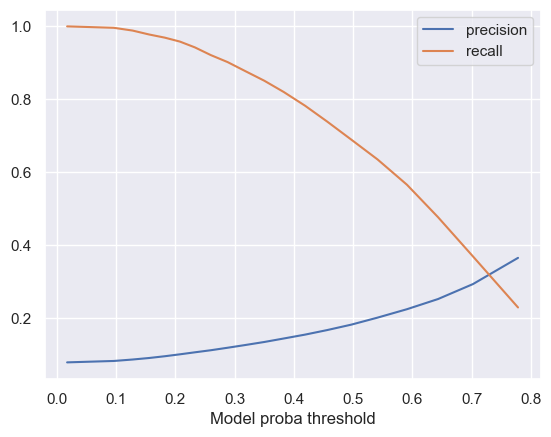

In [97]:
plt.plot(df_scores['probas'], df_scores['precision_score'], label='precision')
plt.plot(df_scores['probas'], df_scores['recall_score'], label='recall')
plt.xlabel('Model proba threshold')
plt.legend()
plt.show()

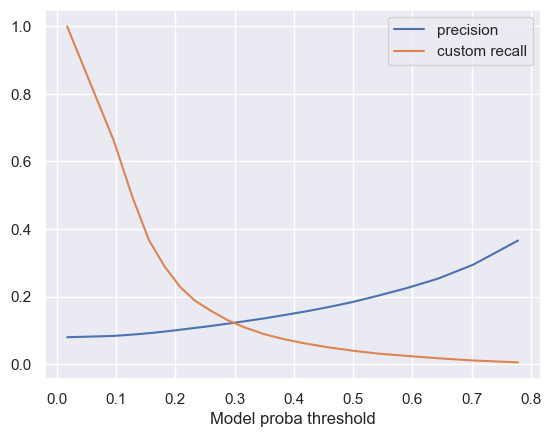

In [98]:
plt.plot(df_scores['probas'], df_scores['precision_score'], label='precision')
plt.plot(df_scores['probas'], df_scores['custom_recall_score'], label='custom recall')
plt.xlabel('Model proba threshold')
plt.legend()
plt.show()

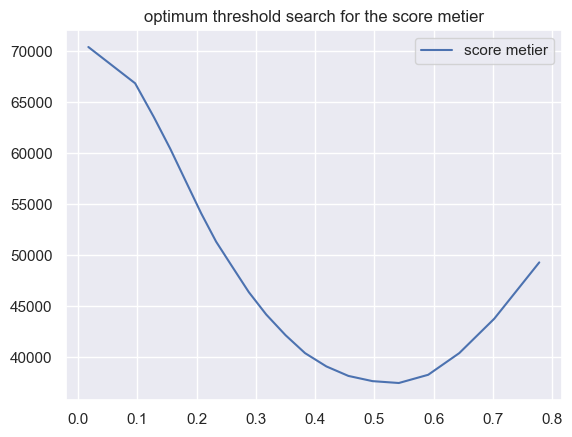

In [99]:
plt.plot(df_scores['probas'], df_scores['score_metier'], label='score metier')
plt.legend()
plt.title('optimum threshold search for the score metier')
plt.show()

In [100]:
df_scores[df_scores['score_metier'] == df_scores['score_metier'].min()]

,precision_score,recall_score,custom_recall_score,score_metier,probas
15,0.202155,0.635377,0.031178,37434,0.541137


In [101]:
target_distrib = y_train.sum() / len(y_train)

In [102]:
max_iter = 21500

In [103]:
lift = (df_results.tail(max_iter)['y_test'].sum() / max_iter) / target_distrib

In [104]:
lift

2.330281898093061

In [105]:
lift * target_distrib # 19% de vrais positifs, soit 2,2 fois mieux que l'aléatoire

0.18958139534883722

In [106]:
# lift = x fois que l'aléatoire

In [107]:
df_results.tail(max_iter).head(1)

,y_test,y_pred_proba
54459,0,0.512955


In [108]:
# le seuil optimal de décision pour notre cas d'étude est appliqué à notre tableau de prédiction de proba pour une nouvelle prédiction binaire

In [110]:
threshold_value = 0.54  # seuil optimal obtenu par le score métier
threshold_index = np.searchsorted(thresholds, threshold_value)
threshold = thresholds[threshold_index]
y_pred_binary = (y_pred_proba >= threshold).astype(int)

### Tracking with MLFLOW

In [111]:
mlflow.set_experiment('P7 model with optimised hyperparameters full data')

run_name = clf.__class__.__name__ + str(int(time.time()))

with mlflow.start_run(run_name=run_name):
    
    # Logging tags
    # run_name.
    mlflow.set_tag(key='Run name', value=run_name)
    # Goal.
    mlflow.set_tag(key='Goal', value='Evaluate best model with optimised hyperparameters')
    # Modeling exp.
    mlflow.set_tag(key='Modeling technique', value=clf.__class__.__name__ )
    
    
    # Enregistrer les hyperparamètres dans MLflow
    for key, value in best_lgbm_params.items():
        mlflow.log_param(key, value)
    
    # Entraîner le modèle
    clf.fit(X_train_std, y_train)
    
    # Prédire les labels sur les données de test
    y_pred = clf.predict(X_test_std)
    
    #Proba estimée d'appartenir à la classe 1 
    y_pred_proba = clf.predict_proba(X_test_std)[:, 1]

    # Calculer les métriques d'évaluation
    (best_score, accuracy, f1, precision, recall) = eval_metrics(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba).round(4)

    # Enregistrer les métriques dans MLflow
    mlflow.log_metric("score_metier", best_score)
    mlflow.log_metric("Roc Auc", roc_auc)
    mlflow.log_metric("Accuracy", accuracy)
    mlflow.log_metric("f1", f1)
    mlflow.log_metric("Precesion", precision)
    mlflow.log_metric("Recall", recall)

    # Prédire les labels sur les données d'entraînement
    predictions = clf.predict(X_train_std)
    signature = infer_signature(X_train_std, predictions)

    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    # Model registry does not work with file store
    if tracking_url_type_store != "file":
        # Register the model
        mlflow.sklearn.log_model(
            clf, "model", registered_model_name="LGBMModel", signature=signature
        )
    else:
        mlflow.sklearn.log_model(clf, "model", signature=signature)

Registered model 'LGBMModel' already exists. Creating a new version of this model...
2023/07/06 10:49:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: LGBMModel, version 8
Created version '8' of model 'LGBMModel'.


# Features importances 

## Global Features importances

In [103]:
from sklearn.inspection import permutation_importance

# Calculer la permutation importance
perm_importance = permutation_importance(clf, X_test_std, y_test, n_repeats=3, n_jobs=-1, random_state=42)

# Récupérer les scores d'importance
importance_scores = perm_importance.importances_mean

In [105]:
importance_scores[0:10]

array([ 4.35872289e-06,  4.35872289e-05, -4.73357306e-03,  3.44339109e-03,
        4.40231012e-03, -6.53808434e-04, -2.44088482e-04,  1.69118448e-03,
       -2.20115506e-03, -2.35371036e-04])

In [109]:
perm_imp_df = pd.DataFrame({'feature_importance': importance_scores, 'feature_name': X_test_std_df.drop(['SK_ID_CURR'], axis=1).columns}) \
.sort_values('feature_importance', ascending=False)

In [110]:
perm_imp_df.head()

,feature_importance,feature_name
4,0.004402,AMT_GOODS_PRICE
72,0.003849,CODE_GENDER_cat
3,0.003443,AMT_ANNUITY
73,0.002284,FLAG_OWN_CAR_cat
7,0.001691,DAYS_BIRTH


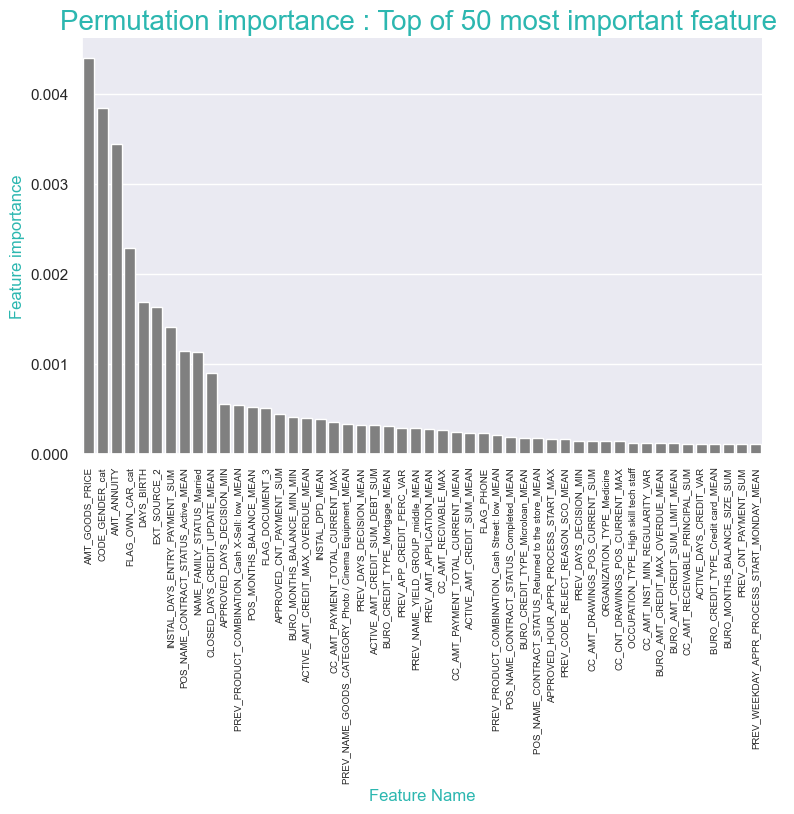

In [111]:
# plot feature importance
g = sns.catplot(data=perm_imp_df.iloc[0:50], kind="bar", y="feature_importance", x="feature_name", color="grey", errorbar=('ci', 95), aspect=2)
plt.title("Permutation importance : Top of 50 most important feature ", color='#2cb7b0', fontsize=20)
g.set_axis_labels("Feature Name", "Feature importance", color='#2cb7b0', fontsize=12)
g.set_xticklabels(rotation=90, fontsize=7)


plt.show()
g.savefig('top50most.png')

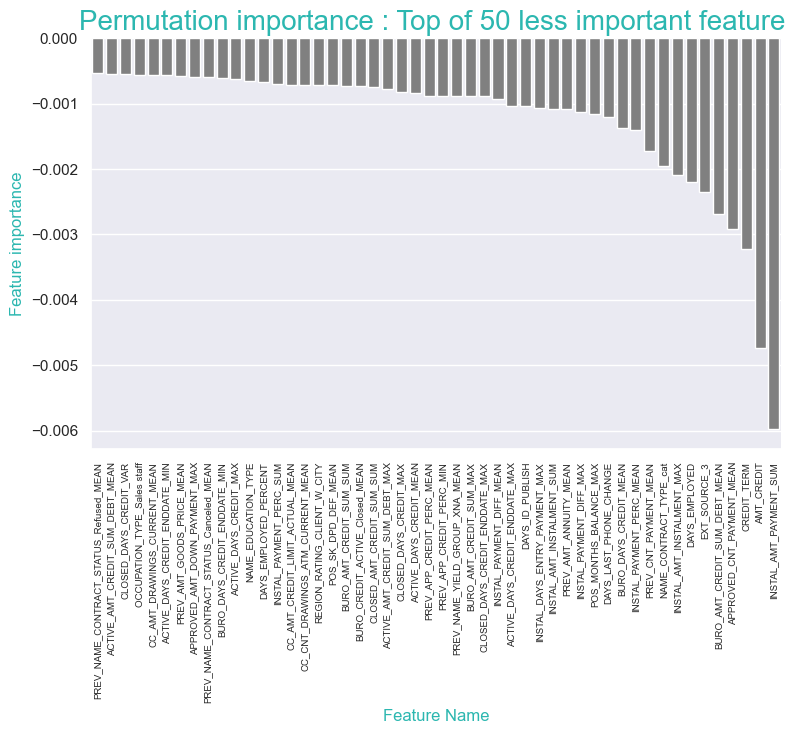

In [118]:
# plot feature importance
g1 = sns.catplot(data=perm_imp_df.iloc[-50:], kind="bar", y="feature_importance", x="feature_name", color="grey", errorbar=('ci', 95), aspect=2)
plt.title("Permutation importance : Top of 50 less important feature ", color='#2cb7b0', fontsize=20)
g1.set_axis_labels("Feature Name", "Feature importance", color='#2cb7b0', fontsize=12)
g1.set_xticklabels(rotation=90, fontsize=7)


plt.show()

## Local Feature importances

In [35]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [36]:
import shap

In [37]:
shap.initjs()

In [94]:
explainer = shap.TreeExplainer(clf)

In [ ]:
# le summary plot montre l'importance de chaque feature dans le modèle, il est ici une mesure de feature importance global. Les features dans le top contribuent davantage au modèle que les variables inférieures et ont donc un pouvoir prédictif élevé. 

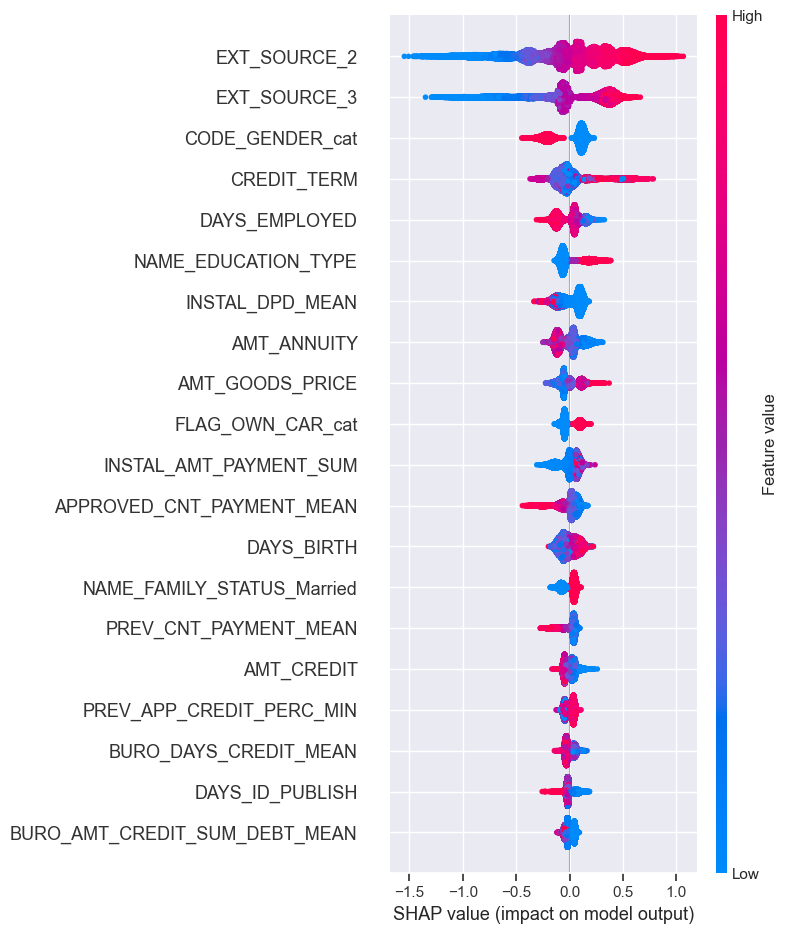

In [50]:
# summary plot pour la target à 0 donc les bons clients
shap.summary_plot(shap_values[0], X_test_std_df.iloc[:, 0:663])

In [57]:
# Tests d'affiche des features importance local pour un ID prêt spécifique

In [57]:
# Tests d'affiche des features importance local pour un ID prêt spécifique

In [70]:
X_test_std_df_sample = X_test_std_df.loc[X_test_std_df['SK_ID_CURR'] == ID_pret].drop('SK_ID_CURR', axis=1)

In [95]:
shap_values = explainer.shap_values(X_test_std_df_sample)

In [72]:
X_test_std_df_sample.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,NAME_CONTRACT_TYPE_cat,CODE_GENDER_cat,FLAG_OWN_CAR_cat,FLAG_OWN_REALTY_cat,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_infrequent_sklearn,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_INCOME_TYPE_infrequent_sklearn,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_With parents,NAME_HOUSING_TYPE_infrequent_sklearn,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_nan,OCCUPATION_TYPE_infrequent_sklearn,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_XNA,ORGANIZATION_TYPE_infrequent_sklearn,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_MEAN,BURO_DAYS_CREDIT_VAR,BURO_DAYS_CREDIT_ENDDATE_MIN,BURO_DAYS_CREDIT_ENDDATE_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_CREDIT_DAY_OVERDUE_MAX,BURO_CREDIT_DAY_OVERDUE_MEAN,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_MAX,BURO_AMT_CREDIT_SUM_MEAN,BURO_AMT_CREDIT_SUM_SUM,BURO_AMT_CREDIT_SUM_DEBT_MAX,BURO_AMT_CREDIT_SUM_DEBT_MEAN,BURO_AMT_CREDIT_SUM_DEBT_SUM,BURO_AMT_CREDIT_SUM_OVERDUE_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_MEAN,BURO_AMT_CREDIT_SUM_LIMIT_SUM,BURO_AMT_ANNUITY_MAX,BURO_AMT_ANNUITY_MEAN,BURO_CNT_CREDIT_PROLONG_SUM,BURO_MONTHS_BALANCE_MIN_MIN,BURO_MONTHS_BALANCE_MAX_MAX,BURO_MONTHS_BALANCE_SIZE_MEAN,BURO_MONTHS_BALANCE_SIZE_SUM,BURO_CREDIT_ACTIVE_Active_MEAN,BURO_CREDIT_ACTIVE_Bad debt_MEAN,BURO_CREDIT_ACTIVE_Closed_MEAN,BURO_CREDIT_ACTIVE_Sold_MEAN,BURO_CREDIT_ACTIVE_nan_MEAN,BURO_CREDIT_CURRENCY_currency 1_MEAN,BURO_CREDIT_CURRENCY_currency 2_MEAN,BURO_CREDIT_CURRENCY_currency 3_MEAN,BURO_CREDIT_CURRENCY_currency 4_MEAN,BURO_CREDIT_CURRENCY_nan_MEAN,BURO_CREDIT_TYPE_Another type of loan_MEAN,BURO_CREDIT_TYPE_Car loan_MEAN,BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN,BURO_CREDIT_TYPE_Consumer credit_MEAN,BURO_CREDIT_TYPE_Credit card_MEAN,BURO_CREDIT_TY

In [101]:
type(shap_values[1][0])

numpy.ndarray

In [99]:
clf.predict_proba(X_test_std_df_sample)

array([[0.16606, 0.83394]])

In [98]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test_std_df_sample, link="logit")

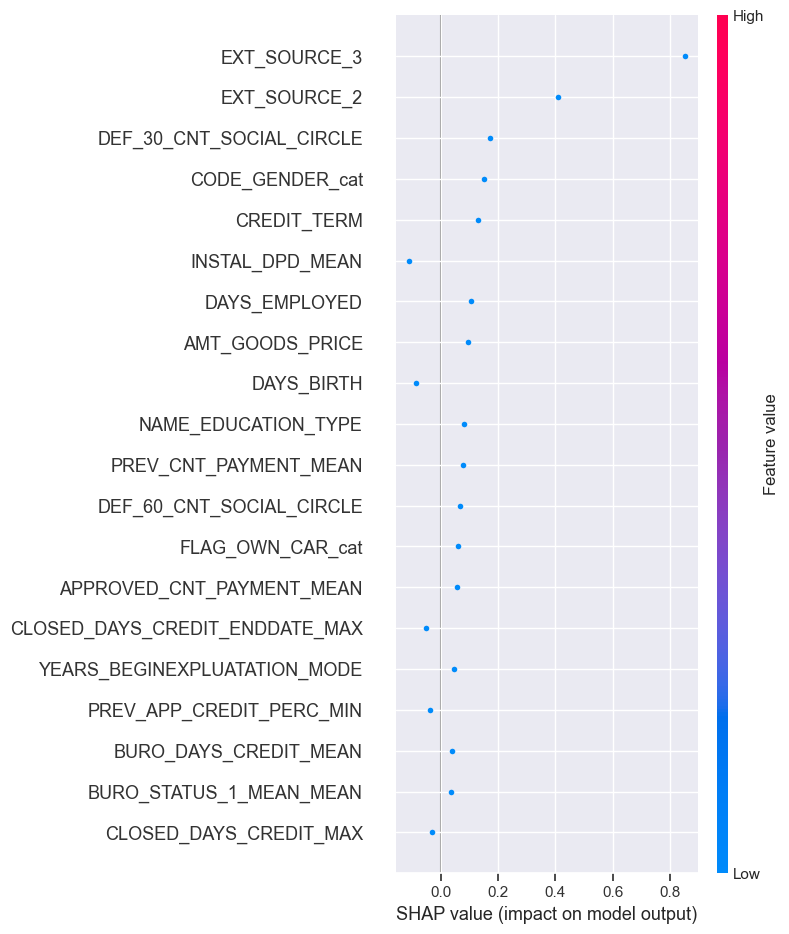

In [93]:
shap.summary_plot(shap_values[1], X_test_std_df_sample)

In [186]:
# export du dataset de test pour streamlit

df_forstream = df_train_full[df_train_full['SK_ID_CURR'].isin(X_test_std_df['SK_ID_CURR'])]

In [187]:
df_forstream.shape

(76475, 680)

In [203]:
col_to_keep=list(df_train_full.columns)[0:85]

In [198]:
df_forstream[col_to_keep].to_parquet('df_forstream.parquet')

In [202]:
# export du dataset de train pour streamlit

df_train_forstream = df_train_full[df_train_full['SK_ID_CURR'].isin(X_train_std_df['SK_ID_CURR'])]

In [204]:
df_train_forstream.shape

(229425, 680)

In [205]:
df_train_forstream[col_to_keep].to_parquet('df_train_forstream.parquet')